# QR Factorization

## Summary and Results Report

The code relevant to the assignment can be be found below. The main program is **QRFactorize()**, which takes a matrix $A$ and returns $R, P, Q$. $R$ is the upper triangular matrix in the factorization $A=QR$, $P$ is a list of permutations done for column swapping, $Q$ is a list of householder transformations that are saved to be used in the least squares solver, the actual matrix $Q$ in $A=QR$ is never computed directly. Here is how my least squares solver works.

- Computer QR factorization to get $R, P, Q$. Details of the QR algorithm are defined below in rigorous detail.
- $\vec{c} = Q\vec{b}$ can be computed with the list of householder transformations
- solve $R\vec{c} = \vec{z}$ through back substiution
- apply saved permutations to $\vec{z}$ and return the permuted vector

I should note that in many parts such as the **QRFactorize()** and **back_substitute()** I used vectorized functionality of python/numpy to speed up the program since writing explicit for loops can make the program dramatically slower.

I tested my solver for for various types of matrices and sizes in the range $[5,10,20,100,150]$. Both square and rectangular matrices were tested. For the most part, my solver was quite stable and would work for reasonable matrices. For random matrices the reconstructed error was not great, mostly due to the linear system not having any correlation to begin with. I also think my algorithm is not correctly working for rectangular matrices where the number of rows is greater than columns. For positive definite and symmetric positive definite matrices you can observe that the reconstructed error was quite good for large sized matrices.

For the problems my least squares solver performed quite well. In problem 1 the least squares solution is quite close to the true solution, but you can also see the error increasing slightly as $\gamma \to \infty$. In problem 2 you can see that all three types of modoels made a reasonable prediction based on the data. The linear and exponential model both made very similar predictions; I am actually unsure if I set up the exponential model correctly. Problem 3 and 5 I plotted the parameterized fit function with the data points, both fit pretty well. In problem 5 I chose a period value $p=\pi / 6$, which was the best fit for many values I tried out in the range of $[\pi/2, 2\pi]$

## Assignment description

*The central program computes a QR factorization of a matrix A, where Q is the product of several orthogonal matrices but is never itself computed There should be separate programs to compute the individual transformations and the result of applying them row-wise ( you can think of it as a column-wise factorization of transpose of A). Another program should use the QR factors to compute solutions of linear least squares problems. The latter requires a program to perform back-substitution, which should be done row-wise. Do not assume that A has full column rank;*

$$
\begin{aligned}
A \vec{x} = \vec{b} \\ \\
A = Q R \implies R\vec{x} = Q^\top \vec{b} \\
\end{aligned}
$$

### Rank Deficient QR

If A does not have full rank then $\hat{R}$ is singular since one of it's diagonal entries $r_{11}, ... , r_{mm}$ is 0. We need to make use of column pivoting with the standard QR algorith. Zero pivots will be moved to the lower right hand corner of $\hat{R}$ 



Where $\hat{A}$ is $A$ with permuted columns, $R_{11} \in \mathbb{R}^{r\times r}$ is nonsingular and upper triangular, and

The basic algorithm for rank deficient QR with householder transformations is

for i in [1,m]:
  - Compute $ \| \vec{a}_{j, i:m} \|_2 \space \forall j \in [i,m] $, that is the 2-norm for every column in the submatrix $A_{i:n,i:m}$
    - Let $ \| \vec{a}_{k,i:n}\|_2$ be the maximum computed 2-norm
    - Swap $\vec{a_i}$ and $\vec{a_k}$ via permuation matrix $P_{ik}$
      - $\hat{A} = A P_{ik}$
    - Compute $Q_i = I - 2\vec{u}\vec{u}^T$
      - $\vec{v} = \vec{a}_{k, i:n} - (-sign(\vec{a}_{k,1})) * (\| \vec{a}_{k, i:n} \|_2 )* \vec{e}_{i,i:n}$
      - $\vec{u} = \frac{\vec{v}}{\| \vec{v} \|_2}$
    - Apply $Q_i$ transformation to $A_{i:n,i:m}$ to transform the first column to $[r_i, 0, ... , 0]^T$

$$
\begin{aligned}
Q_rQ_{r-1}...Q_{1}\hat{A} = 

\begin{bmatrix}
R_{11} & R_{12} \\
0 & 0
\end{bmatrix}	

= R \\ \\
\implies \hat{A} = QR
\end{aligned}
$$


### Applying to least squares problem

After QR we have matrix $\hat{A}$ which is permuted $A$, therefore we apply the same permuation to $\vec{x} \implies \hat{\vec{x}} = P\vec{x}$

We then have the system $\hat{A} \hat{\vec{x}} = b \implies R\hat{\vec{x}} = Q^T\vec{b} = \vec{c}$

$$
\begin{aligned}

\begin{bmatrix}
R_{11} & R_{12} \\
0 & 0
\end{bmatrix}	

\begin{bmatrix}
\hat{\vec{x_1}} \\
\hat{x_2}
\end{bmatrix}

= 

\begin{bmatrix}
\hat{\vec{c}} \\
\vec{d}
\end{bmatrix}

\end{aligned}
$$

The residual for this system is then

$$
\begin{aligned}

\vec{s} = \begin{bmatrix}
\hat{\vec{c}} - R_{11}\hat{\vec{x_1}}  - R_{12}\hat{\vec{x_2}} \\
\vec{d} 
\end{bmatrix}	\\ \\

\end{aligned}
$$

Where the error is then

$$
\begin{aligned}

\| \vec{s} \|_2  = \sqrt{ \| \hat{\vec{c}} - R_{11}\hat{\vec{x_1}} - R_{12}\hat{\vec{x_2}} \|^2_2 + \| \vec{d} \|^2_2 }

\end{aligned}

$$

We minimize the error in the least squares problem, therefore

$$
\begin{aligned}

\hat{\vec{x}} = 

\begin{bmatrix}
\hat{\vec{x_1}} \\
\hat{x_2}
\end{bmatrix}

=  \argmin_{\vec{x}} \| \hat{A} \vec{x} - \vec{b} \|_2

\iff  

\hat{\vec{x}} = \argmin_{\vec{x}} \| Q^T\vec{b} - R_{11}\vec{x_1} - R_{12}\vec{x_2} \|_2 

\end{aligned}
$$

In [1]:
import numpy as np
import pynla as nla
from matplotlib import pyplot as plt

def dump_matrix(M):
  n,m = np.shape(M)
  for y in range(n):
    for x in range(m):
      print(M[y,x], end=' ')
    print()
  print()

In [276]:
def apply_householder_transforms(H, b):
  c = b.copy()
  for Q in H:
    c = Q @ c
  return c

def back_substitute(R, c):
  r = min(np.shape(R))
  z = np.zeros(R.shape[1])

  for i in reversed(range(r)):
    if abs(R[i,i]) > 1e-10:
      z[i] = ( c[i] -  R[i, i+1:]@z[i+1:] ) / R[i,i]
      
  return z

def householder_reflection(v):
  a = v.copy()
  a[0] += np.sign(a[0]) * np.linalg.norm(a)
  u = a / np.linalg.norm(a)
  return u

def QRFactorize(A):
  n, m = np.shape(A)
  P = np.arange(m)
  R = A.copy().astype(float)
  Q = []

  # for each column
  for i in range(min(m,n)):

    # Compute 2-norm of every column in submatrix A[i::n, i::m]
    # Get the maximum 2-norm computed A[k], swap that column with column A[i]
    col_norms = np.linalg.norm(R[i:, i:], axis=0)
    k = np.argmax(col_norms) + i
    if k != i:
      R[:, [i, k]] = R[:, [k, i]]
      P[[i, k]] = P[[k, i]]

    # Make sure first entry is not zero
    if A[i, i] < 1e-10:
      k = np.argmax(R[i, i:m])
      R[:, [i, k]] = R[:, [k, i]]
      P[[i, k]] = P[[k, i]]

    # Compute Householder transformation
    u = householder_reflection(R[i:, i])
    Q_i = np.eye(n)
    Q_i[i:, i:] -= 2 * np.outer(u,u)
    R = Q_i @ R

    Q.append(Q_i)

  return R, P, Q

def least_squares_solve(A, b):
  n, m = np.shape(A)
  R, P, H = QRFactorize(A)
  c = apply_householder_transforms(H, b)

  z = back_substitute(R[:m, :m], c[:m])
  inv_P = np.argsort(P)
  x = z[inv_P]
  return x


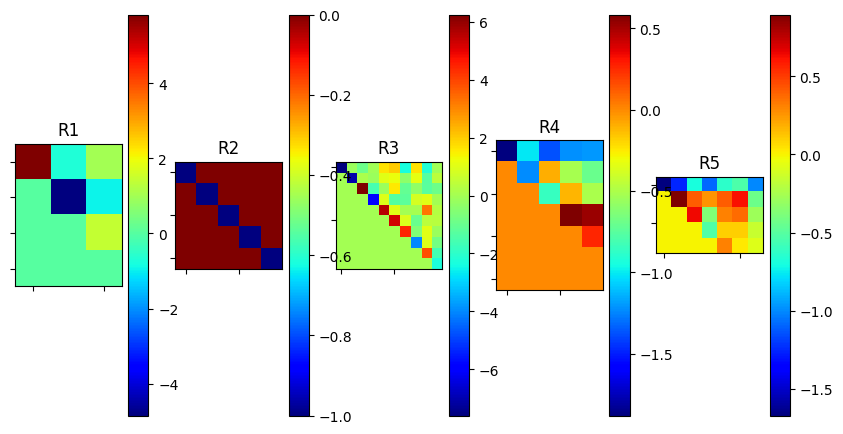

In [277]:
A = np.array([[1,-1,4], [1,4,-2], [1,4,2], [1,-1,0]])
R1, P1, H1 = QRFactorize(A)

B = np.eye(5)
R2, P2, H2 = QRFactorize(B)

A_spd = nla.create_pd_matrix(10, v_range=[0.1,10])
R3, P3, H3 = QRFactorize(A_spd)

A_rand = np.random.rand(7,5)
R4, P4, H4 = QRFactorize(A_rand)

A_rand2 = np.random.rand(5,7)
R5, P5, H5 = QRFactorize(A_rand2)

figure, axis = plt.subplots(1, 5, figsize=(10,10))
axis[0].set_title("R1")
axis[0].set_xticklabels([])
axis[0].set_yticklabels([])
plt.colorbar(axis[0].imshow(R1, cmap='jet'), ax=axis[0])

axis[1].set_title("R2")
axis[1].set_xticklabels([])
axis[1].set_yticklabels([])
plt.colorbar(axis[1].imshow(R2, cmap='jet'), ax=axis[1])

axis[2].set_title("R3")
axis[2].set_xticklabels([])
axis[2].set_yticklabels([])
plt.colorbar(axis[2].imshow(R3, cmap='jet'), ax=axis[2])

axis[3].set_title("R4")
axis[3].set_xticklabels([])
axis[3].set_yticklabels([])
plt.colorbar(axis[3].imshow(R4, cmap='jet'), ax=axis[3])

axis[4].set_title("R5")
axis[4].set_xticklabels([])
axis[4].set_yticklabels([])
plt.colorbar(axis[4].imshow(R5, cmap='jet'), ax=axis[4])

1.2532433549999032e-12
118.62105249433246
1.4542331628506458e-12


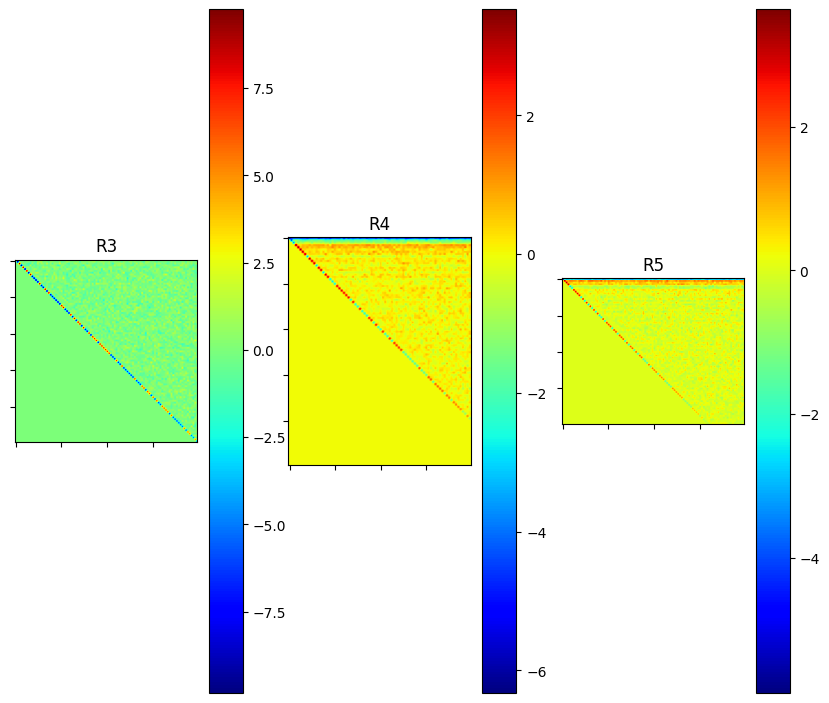

In [278]:
b = np.arange(0,100)
b_1 = np.arange(0, 80)

A_pd = nla.create_pd_matrix(100, v_range=[0.1,10])
R3, P3, H3 = QRFactorize(A_pd)

x = least_squares_solve(A_pd, b)
b_rec = A_pd@x
error = np.linalg.norm(b - b_rec)
print(error)

A_rand = np.random.rand(100, 80)
R4, P4, H4 = QRFactorize(A_rand)

x = least_squares_solve(A_rand, b)
b_rec = A_rand@x
error = np.linalg.norm(b - b_rec)
print(error)

A_rand2 = np.random.rand(80, 100)
R5, P5, H5 = QRFactorize(A_rand2)

x = least_squares_solve(A_rand2, b_1)
b1_rec = A_rand2@x
error = np.linalg.norm(b_1 - b1_rec)
print(error)

figure, axis = plt.subplots(1, 3, figsize=(10,10))

axis[0].set_title("R3")
axis[0].set_xticklabels([])
axis[0].set_yticklabels([])
plt.colorbar(axis[0].imshow(R3, cmap='jet'), ax=axis[0])

axis[1].set_title("R4")
axis[1].set_xticklabels([])
axis[1].set_yticklabels([])
plt.colorbar(axis[1].imshow(R4, cmap='jet'), ax=axis[1])

axis[2].set_title("R5")
axis[2].set_xticklabels([])
axis[2].set_yticklabels([])
plt.colorbar(axis[2].imshow(R5, cmap='jet'), ax=axis[2])

In [279]:
# Example usage:
A = np.array([[5, -2, 2], [4, -3, 4], [4, -6, 7]], dtype=float)
b = np.array([1, 2, 3], dtype=float)
x = least_squares_solve(A, b)

print(A@x)

[1. 2. 3.]


## Problems 

### 1

In [280]:
for k in range(6,13):
  g = 10 ** k
  A = np.array([[0, 2, 0], [g, g, 0], [g, 0, g], [0, 1, 1]], dtype=float)
  b = np.array([2, 2*g, 2*g, 2], dtype=float)

  # Estimate rank using QR
  R, P, H = QRFactorize(A)

  rank = 0
  for i in range(3):
    if np.abs(R[i,i]) > 1e-10:
      rank += 1

  x = least_squares_solve(A, b)

  b_reconstructed = A@x

  error = np.linalg.norm(b - b_reconstructed)

  print(f"For gamma = 10^{k}:")
  print("Estimated Rank of A:", rank)
  print("Solution x:", x)
  print("Reconstruction error:", error)
  print("-" * 50)

For gamma = 10^6:
Estimated Rank of A: 3
Solution x: [1. 1. 1.]
Reconstruction error: 1.9484721804868955e-10
--------------------------------------------------
For gamma = 10^7:
Estimated Rank of A: 3
Solution x: [1. 1. 1.]
Reconstruction error: 3.815696738543079e-09
--------------------------------------------------
For gamma = 10^8:
Estimated Rank of A: 3
Solution x: [1. 1. 1.]
Reconstruction error: 8.594841872006886e-09
--------------------------------------------------
For gamma = 10^9:
Estimated Rank of A: 3
Solution x: [0.99999999 1.00000001 1.00000001]
Reconstruction error: 3.999669104568239e-08
--------------------------------------------------
For gamma = 10^10:
Estimated Rank of A: 3
Solution x: [1.00000032 0.99999968 0.99999968]
Reconstruction error: 9.020587841645826e-07
--------------------------------------------------
For gamma = 10^11:
Estimated Rank of A: 3
Solution x: [1.00000004 0.99999996 0.99999996]
Reconstruction error: 1.1701255482269512e-07
---------------------

### 2

Linear Model Prediction for 2024: 10.451689391671263
Quadratic Model Prediction for 2024: 10.702383263681668
Exponential Model Prediction for 2024: 10.456600901941044


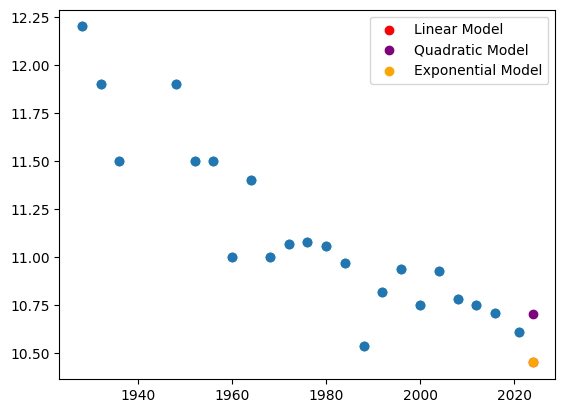

In [242]:
years = np.array([1928, 1932, 1936, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 
                  1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 
                  2016, 2021], dtype=float)
times = np.array([12.20, 11.90, 11.50, 11.90, 11.50, 11.50, 11.00, 11.40, 11.00, 11.07, 
                   11.08, 11.06, 10.97, 10.54, 10.82, 10.94, 10.75, 10.93, 10.78, 10.75, 
                   10.71, 10.61], dtype=float)

plt.plot(years, times, 'o')
plt.scatter(years, times)

def predict_time_2024(A_func):
  A = A_func(years)
  b = times
  x = least_squares_solve(A,b)
  pred = A_func(np.array([2024])) @ x
  return pred[0]

predict_linear = predict_time_2024(lambda x: np.column_stack((x, np.ones_like(x))))
print("Linear Model Prediction for 2024:", predict_linear)
plt.scatter(2024, predict_linear, color='Red', label='Linear Model')

predict_quadratic = predict_time_2024(lambda x: np.column_stack((x**2, x, np.ones_like(x))))
print("Quadratic Model Prediction for 2024:", predict_quadratic)
plt.scatter(2024, predict_quadratic, color='Purple', label='Quadratic Model')

predict_exponential = predict_time_2024(lambda x: np.column_stack((np.log(x), np.ones_like(x))))
print("Exponential Model Prediction for 2024:", predict_exponential)
plt.scatter(2024, predict_exponential, color='Orange', label='Exponential Model')

plt.legend()
plt.show()

### 3

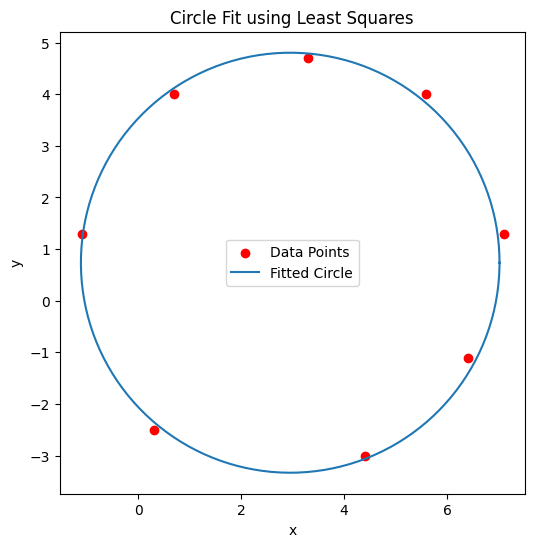

In [ ]:
x = np.array([0.7, 3.3, 5.6, 7.1, 6.4, 4.4, 0.3, -1.1], dtype=float)
y = np.array([4.0, 4.7, 4.0, 1.3, -1.1, -3.0, -2.5, 1.3], dtype=float)

A = np.column_stack((2*x, 2*y, np.ones_like(x)))
b = x**2 + y**2

# Solve for c1, c2, and c3
c1, c2, c3 = least_squares_solve(A, b)
r = np.sqrt(c1**2 + c2**2 + c3)

# Plot data and fitted circle
theta = np.linspace(0, 2*np.pi, 300)
circle_x = c1 + r * np.cos(theta)
circle_y = c2 + r * np.sin(theta)

plt.figure(figsize=(6,6))
plt.scatter(x, y, color='red', label='Data Points')
plt.plot(circle_x, circle_y, label='Fitted Circle')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()

### 4

In [ ]:
L = np.array([5,6,7], dtype=float)
F = np.array([1,2,4], dtype=float)

# L = a + bF

A = np.column_stack((np.ones_like(F), F))

a, b = least_squares_solve(A, L)

print("Normal length a=" + str(a))

Normal length a=4.5


### 5

38.05303243244929


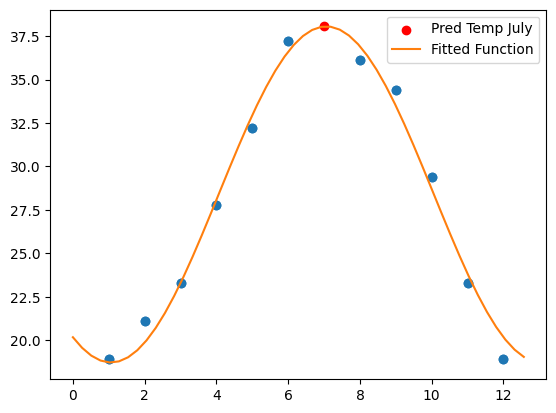

In [232]:
x = np.array([1,2,3,4,5,6,8,9,10,11,12], dtype=float)
y = np.array([18.9, 21.1, 23.3, 27.8, 32.2, 37.2, 36.1, 34.4, 29.4, 23.3, 18.9], dtype=float)

plt.plot(x, y, 'o')
plt.scatter(x, y)

p = np.pi / 6
A = np.column_stack((np.ones_like(x), np.cos(p*x), np.sin(p*x)))

a,b,c = least_squares_solve(A, y)

pred = a + b*np.cos(p*7) + c*np.sin(p*7)

print(pred)
plt.scatter(7, pred, color='Red', label='Pred Temp July')

theta = np.linspace(0, 4*np.pi)
fit = a + b * np.cos(p*theta) + c*np.sin(p*theta)

plt.plot(theta, fit, label='Fitted Function')
plt.legend()